# Obligatorio - Taller Agentes Inteligentes 2024

Vamos a usar el ambiente Galaxian de Gymnasium:
- Link: https://gymnasium.farama.org/environments/atari/galaxian/

En este caso, el juego está programado como un ambiente de Farama Gymnasium, cumpliendo con las interfaces que hemos trabajado en el curso.


El objetivo del juego consta de lograr que nuestro personaje llegue al final de la pantalla, sin ser destruido por las naves enemigas.

![](./assets/images/galaxian.gif)

El objetivo es resolver el juego utilizando Deep Q Learning y Double Deep Q Learning, comparando sus resultados.


## Tareas:


1. Completar el código faltante en este notebook (y archivos asociados).


2. Entrenar un agente de Deep Q Learning (DQN) para cada ambiente tal que éste sea capaz de resolverlo.


3. Entrenar un agente de Double Deep Q Learning (DDQN) para cada ambiente tal que éste sea capaz de resolverlo.


4. Graficar las recompensas obtenidas para cada ambiente por cada agente (Ambos agentes resolviendo el ambiente 1 en una misma gráfica, idem para el ambiente 2). Escribir al menos 2 conclusiones de cada grafica. 


5. Grabar un video de cada agente resolviendo cada problema (pueden descargar el video desde colab y entregarlos dentro de un zip).


Recuerden que pueden usar la GPU en google colab para agilizar el entrenamiento. 
***


Fecha de entrega: **25/06** 21hs por gestión (gestion.ort.edu.uy). Pueden trabajar en grupos de hasta 3 estudiantes. 
***

Instalación de librerías. Se fija la versión de gym, dado que para dicha versión las ROMS de los juegos ya estan includias y se evita su instalación separada lo que puede originar problemas.

In [1]:
# #%%capture
# !pip install pyvirtualdisplay 
# !apt-get install -y xvfb python-opengl ffmpeg 
# !pip install opencv-python
# !pip install torchsummary
# !pip install pyglet==1.4.9
# !pip install torchvision==0.15.2 -f https://download.pytorch.org/whl/cu118/torchvision-0.18.0%2Bcu118-cp311-cp311-win_amd64.whl
# !pip install torch==2.1.0+cu118 -f https://download.pytorch.org/whl/cu118/torch-2.1.0%2Bcu118-cp311-cp311-win_amd64.whl
# !pip install flappy-bird-env
# !pip install swig
# !pip install matplotlib
# !pip install moviepy
# !pip install gymnasium[atari]
# !pip install gymnasium[accept-rom-license]

Imports y configuraciones de ambiente

In [2]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import utils
import gymnasium

Checkeo de devices

In [3]:
torch.zeros(1).cuda()

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Running on {DEVICE}")

print("Cuda Available:", torch.cuda.is_available())

Running on cuda:0
Cuda Available: True


Setting de seeds

In [4]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

Validacion del ambiente

In [5]:
ENV_NAME = "ALE/Galaxian-v5"

env = utils.make_env(ENV_NAME, render_mode="rgb_array")

print("Actions #",env.action_space)
print(env.observation_space.shape)
env.reset()
next_state, reward, terminated, truncated, info = env.step(action=0)

print(f"{next_state.shape},\n {reward},\n {terminated},\n {info}")

Actions # Discrete(6)
(4, 84, 84)
(4, 84, 84),
 0.0,
 False,
 {'lives': 4, 'episode_frame_number': 16, 'frame_number': 16}


In [6]:
next_state, reward, terminated, truncated, info = env.step(action=0)
#torch.Tensor(next_state[:])

In [7]:
#utils.show_state(env)

In [8]:
#env.render()

from IPython.display import HTML
from pyvirtualdisplay import Display

##display = Display(visible=0, size=(1400, 900),color_depth=16)
#isplay.start()

wrapped_env = utils.wrap_env(env)
state = wrapped_env.reset()

# Start the recorder
wrapped_env.start_video_recorder()

while True:        
  wrapped_env.render()
  state, reward, terminated, truncated, info = wrapped_env.step(wrapped_env.action_space.sample())
  if terminated or truncated:
    break

####
# Don't forget to close the video recorder before the env!
wrapped_env.close_video_recorder()

# Close the environment

wrapped_env.close()

In [9]:
#utils.show_video()

# Deep Q Learning


Recomendamos empezar implementando Deep Q Learning (paper presentado por DeepMind, pueden encontrar el mismo en arxiv: https://arxiv.org/pdf/1312.5602.pdf0).

***

En las celdas siguientes dejamos el código que deben implementar asi como una explicación del mismo.

# Memoria

El algoritmo de Deep Q Learning presentado en el paper utiliza una memoria (llamada Replay Memory) para almacenar transiciones pasadas. Tuplas que contienen un estado base, la accion tomada, la recompensa obtenida, una bandera que indica si el siguiente estado es final o no; y el estado siguiente.

Esta memoria es circular, es decir, tiene un límite maximo de elementos y una vez esté llena comienza a reemplazar los elementos más viejos.

Vamos a necesitar crear una función **sample** que obtiene una mustra aleatoria de elementos de la memoria.  Esto puede ser una lista de Transiciones o listas separadas (pero alineadas) de los elementos que las componen.

***

Para implementar esta funcionalidad se debe modificar el archivo **replay_memory.py**


In [10]:
from replay_memory import ReplayMemory

# Modelo

Vamos a usar un mismo modelo FeedForward para estos dos problemas (entrenado en cada problema particular). Recomendamos simplicidad en la creación del mismo, pero tienen total libertad al momento de implementarlo.

***
Para implementar esta funcionalidad se debe modificar el archivo **dqn_cnn_model.py**


In [11]:
from dqn_cnn_model import DQN_CNN_Model

test_env = utils.make_env(ENV_NAME, render_mode="rgb_array")

test_net = DQN_CNN_Model(test_env.observation_space.shape, test_env.action_space.n).to(DEVICE)

from torchsummary import summary
summary(test_net, test_env.observation_space.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 42, 42]           4,160
            Conv2d-2           [-1, 64, 21, 21]          65,600
            Conv2d-3           [-1, 64, 10, 10]          65,600
            Conv2d-4             [-1, 64, 5, 5]          65,600
              ReLU-5             [-1, 64, 5, 5]               0
         MaxPool2d-6             [-1, 64, 2, 2]               0
           Flatten-7                  [-1, 256]               0
            Linear-8                  [-1, 256]          65,792
            Linear-9                    [-1, 6]           1,542
Total params: 268,294
Trainable params: 268,294
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forward/backward pass size (MB): 1.16
Params size (MB): 1.02
Estimated Total Size (MB): 2.29
-------------------------------------------

# Agente

Vamos a definir una clase agente, encargado de interactuar con el ambiente y entrenar los modelos. Los métdos definidos deben funcionar para ambos problemas simplemente cambiando el modelo a utilizar para cada ambiente.

Abajo dejamos un esqueleto del mismo y las funciones a completar. Recomendamos no alterar la estructura del mismo, pero pueden definir las funciones auxiliares que consideren necesarias.

Una aclaracion particular es sobre los últimos tres parametros del agente, representan los valores de epsilon_inicial, epsilon_final y el tiempo (numero de steps) que tardamos en llegar del epsilon final al inicial (puede decrementarlo de forma lineal o exponencial en el número de steps).

***

Para implementar esta funcionalidad se debe modificar los archivos **abstract_agent.py**, **dqn_agent.py** y **double_dqn_agent.py**.

Funciones a completar:


1. init: que inicializa los parametros del agente.

2. compute_epsilon: que computa el valor actual de epsilon en base al número de pasos actuales.

3. select_action: Seleccionando acciones "epsilongreedy-mente" si estamos entranando y completamente greedy en otro caso.

4. train: que entrena el agente por un número dado de episodios de largo determinado.

5. record_test_episode: para grabar un episodio con el agente siempre seleccionando la mejor accion conocida.

# Entrenamiento

Para entrenar van a necesitar definir:

1. El ambiente.
2. Una instancia del modelo a utilizar para el problema (ej: `model = DQNModel(espacio_obs, num_acciones)`.
3. La función para procesar los estados (phi en el paper) que es necesaria para poder usar el modelo de Pytorch con las representaciones de gym.

Una vez definido pueden llamar a la función train del agente para entrenarlo y problar las demás funciones.

***

Una de las cosas que recomendamos hacer para probar los algoritmos es entrenar el agente por una cantidad X de episodios, grabar un video para observar progreso, volver a entrenar el mismo agente y volver a grabar un video, todas las veces que considere necesario.

***

In [12]:
def process_state(obs, DEVICE):
    return torch.tensor(obs[:], device=DEVICE).unsqueeze(0)

#Hiperparámetros de entrenamiento del agente DQN
TOTAL_STEPS =1000000
EPISODES = 100
STEPS = 10000

EPSILON_INI = .9
EPSILON_MIN = 0.1
EPSILON_DECAY = 0.99998599985
EPSILON_TIME = 1000
EPISODE_BLOCK = 10

BATCH_SIZE = 32
BUFFER_SIZE = 10000

GAMMA = 0.99
LEARNING_RATE = 1e-4

In [13]:
from dqn_agent import DQNAgent
env = utils.make_env(ENV_NAME, render_mode="rgb_array")

# Cada vez que hacemos un experimento reseteamos la semilla para tener reproducibilidad
env.unwrapped.seed(42)
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

net = DQN_CNN_Model(env.observation_space.shape, env.action_space.n).to(DEVICE)


#gym_env, model, obs_processing_func, memory_buffer_size, batch_size, learning_rate, gamma, epsilon_i, epsilon_f, epsilon_anneal_time
agent = DQNAgent(env, net, process_state, BUFFER_SIZE, BATCH_SIZE, LEARNING_RATE, GAMMA, epsilon_i= EPSILON_INI, epsilon_f=EPSILON_MIN, epsilon_anneal_time=EPSILON_TIME, epsilon_decay = EPSILON_DECAY, episode_block = EPISODE_BLOCK)

In [14]:
rewards = agent.train(300, STEPS, TOTAL_STEPS, writer_name = ENV_NAME)

  0%|          | 0/300 [00:00<?, ? episodes/s]

  0%|          | 1/300 [00:33<2:44:53, 33.09s/ episodes]

Episode 0 - Avg. Reward over the last 10 episodes 1410.0 epsilon 0.895276349922934 total steps 424


  4%|▎         | 11/300 [03:07<1:15:01, 15.58s/ episodes]

Episode 10 - Avg. Reward over the last 10 episodes 677.0 epsilon 0.8766155263465646 total steps 2120


  7%|▋         | 21/300 [05:20<53:07, 11.43s/ episodes]  

Episode 20 - Avg. Reward over the last 10 episodes 627.0 epsilon 0.8603593748551368 total steps 3631


 10%|█         | 31/300 [06:48<45:01, 10.04s/ episodes]

Episode 30 - Avg. Reward over the last 10 episodes 520.0 epsilon 0.8473256231007843 total steps 4866


 14%|█▎        | 41/300 [08:43<57:01, 13.21s/ episodes]

Episode 40 - Avg. Reward over the last 10 episodes 749.0 epsilon 0.8304645878454462 total steps 6496


 17%|█▋        | 51/300 [10:22<39:17,  9.47s/ episodes]

Episode 50 - Avg. Reward over the last 10 episodes 548.0 epsilon 0.8165174108748875 total steps 7873


 20%|██        | 61/300 [12:40<55:05, 13.83s/ episodes]  

Episode 60 - Avg. Reward over the last 10 episodes 743.0 epsilon 0.797220874984125 total steps 9823


 24%|██▎       | 71/300 [14:26<48:01, 12.58s/ episodes]

Episode 70 - Avg. Reward over the last 10 episodes 567.0 epsilon 0.7830376852896949 total steps 11291


 27%|██▋       | 81/300 [16:13<43:00, 11.78s/ episodes]

Episode 80 - Avg. Reward over the last 10 episodes 589.0 epsilon 0.7689369500825644 total steps 12781


 30%|███       | 91/300 [17:58<40:05, 11.51s/ episodes]

Episode 90 - Avg. Reward over the last 10 episodes 601.0 epsilon 0.7552557315392946 total steps 14257


 34%|███▎      | 101/300 [20:04<42:31, 12.82s/ episodes]

Episode 100 - Avg. Reward over the last 10 episodes 715.0 epsilon 0.7392447006695727 total steps 16024


 37%|███▋      | 111/300 [22:08<34:52, 11.07s/ episodes]

Episode 110 - Avg. Reward over the last 10 episodes 620.0 epsilon 0.7238694073467108 total steps 17763


 40%|████      | 121/300 [24:02<36:14, 12.15s/ episodes]

Episode 120 - Avg. Reward over the last 10 episodes 649.0 epsilon 0.7100755633369837 total steps 19360


 44%|████▎     | 131/300 [26:06<35:51, 12.73s/ episodes]

Episode 130 - Avg. Reward over the last 10 episodes 699.0 epsilon 0.6954351981035369 total steps 21095


 47%|████▋     | 141/300 [27:45<27:07, 10.24s/ episodes]

Episode 140 - Avg. Reward over the last 10 episodes 645.0 epsilon 0.6840335071379701 total steps 22476


 50%|█████     | 151/300 [30:11<41:10, 16.58s/ episodes]

Episode 150 - Avg. Reward over the last 10 episodes 831.0 epsilon 0.6675733829271816 total steps 24518


 54%|█████▎    | 161/300 [32:32<31:57, 13.80s/ episodes]

Episode 160 - Avg. Reward over the last 10 episodes 710.0 epsilon 0.652342187258055 total steps 26461


 57%|█████▋    | 171/300 [34:54<27:10, 12.64s/ episodes]

Episode 170 - Avg. Reward over the last 10 episodes 643.0 epsilon 0.6392986519002974 total steps 28168


 60%|██████    | 181/300 [36:40<18:04,  9.11s/ episodes]

Episode 180 - Avg. Reward over the last 10 episodes 543.0 epsilon 0.6289867031757638 total steps 29547


 64%|██████▎   | 191/300 [38:26<21:30, 11.84s/ episodes]

Episode 190 - Avg. Reward over the last 10 episodes 517.0 epsilon 0.6183564216186007 total steps 30997


 67%|██████▋   | 201/300 [40:25<19:34, 11.86s/ episodes]

Episode 200 - Avg. Reward over the last 10 episodes 658.0 epsilon 0.6065478704020151 total steps 32643


 70%|███████   | 211/300 [42:03<14:30,  9.78s/ episodes]

Episode 210 - Avg. Reward over the last 10 episodes 448.0 epsilon 0.5975094933210328 total steps 33929


 74%|███████▎  | 221/300 [44:01<12:42,  9.65s/ episodes]

Episode 220 - Avg. Reward over the last 10 episodes 653.0 epsilon 0.5867888251258461 total steps 35485


 77%|███████▋  | 231/300 [46:03<13:57, 12.13s/ episodes]

Episode 230 - Avg. Reward over the last 10 episodes 660.0 epsilon 0.5759592132064307 total steps 37092


 80%|████████  | 241/300 [48:06<14:37, 14.86s/ episodes]

Episode 240 - Avg. Reward over the last 10 episodes 551.0 epsilon 0.5654813006828884 total steps 38682


 84%|████████▎ | 251/300 [50:17<09:37, 11.78s/ episodes]

Episode 250 - Avg. Reward over the last 10 episodes 657.0 epsilon 0.5545271602550843 total steps 40383


 87%|████████▋ | 261/300 [52:39<10:26, 16.07s/ episodes]

Episode 260 - Avg. Reward over the last 10 episodes 751.0 epsilon 0.543029959253039 total steps 42213


 90%|█████████ | 271/300 [55:01<07:56, 16.42s/ episodes]

Episode 270 - Avg. Reward over the last 10 episodes 717.0 epsilon 0.5317147713464351 total steps 44061


 94%|█████████▎| 281/300 [57:03<02:58,  9.41s/ episodes]

Episode 280 - Avg. Reward over the last 10 episodes 644.0 epsilon 0.5223645839532595 total steps 45625


 97%|█████████▋| 291/300 [58:50<01:48, 12.03s/ episodes]

Episode 290 - Avg. Reward over the last 10 episodes 566.0 epsilon 0.514050799775441 total steps 47045


100%|██████████| 300/300 [1:00:54<00:00, 12.18s/ episodes]

Episode 300 - Avg. Reward over the last 10 episodes 652.0 epsilon 0.5049187509811559 total steps 48638


# Videos

Para grabar los videos hacemos uso de la funcion `record_test_episode`  definida en nuestro agente.

Dejamos un ejemplo de como hacerlo:

In [15]:
#initial environment
env = gymnasium.make(ENV_NAME, render_mode="rgb_array")
env = utils.SkipFrame(env, 4)
wrapped_env = utils.wrap_env(env)
agent.record_test_episode(wrapped_env)

e:\Downloads\Programs\conda\envs\TorchImage\lib\site-packages\gymnasium\wrappers\record_video.py:94: UserWarning: WARN: Overwriting existing videos at c:\Users\juan1\OneDrive\Desktop\letra\video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
e:\Downloads\Programs\conda\envs\TorchImage\lib\site-packages\gymnasium\utils\passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


Moviepy - Building video c:\Users\juan1\OneDrive\Desktop\letra\video\rl-video-episode-0.mp4.
Moviepy - Writing video c:\Users\juan1\OneDrive\Desktop\letra\video\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\juan1\OneDrive\Desktop\letra\video\rl-video-episode-0.mp4


RuntimeError: Input type (unsigned char) and bias type (float) should be the same

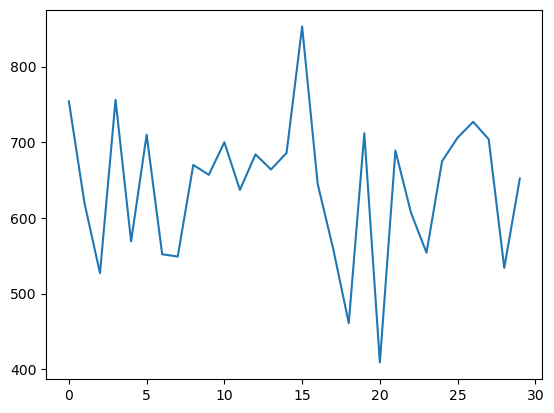

In [16]:
import matplotlib.pyplot as plt

average_range = EPISODE_BLOCK
episode_ticks = int(len(rewards) / average_range)

avg_rewards = np.array(rewards).reshape((episode_ticks, average_range))
avg_rewards = np.mean(avg_rewards, axis=1)

plt.plot(range(len(avg_rewards)), avg_rewards)

# Double Deep Q Learning

Una variante del clásico algoritmo Q Learning, es Double Q Learning, este surge como solución al problema de sesgo de maximización. Esta variante fue rápidamente adaptada con tecnicás de optimización por decenso de gradientes (https://arxiv.org/pdf/1509.06461.pdf). Recomendamos leer el algoritmo del libro de Sutton y Barto para maximizar su entendimiento del mismo.

***

Vamos a utilizar el mismo modelo de red neuronal creado para el problema anterior y la misma implementación de memoria, dejamos un esqueleto de un agente de Double Deep Q learning para completar en el archivo **double_dqn_agent.py**

In [ ]:

env = gymnasium.make(ENV_NAME)
from double_dqn_agent import DoubleDQNAgent
# Cada vez que hacemos un experimento reseteamos la semilla para tener reproducibilidad
env.seed(42)
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

modelo_a = DQN_CNN_Model(env.observation_space.shape, env.action_space.n).to(DEVICE)
modelo_b = DQN_CNN_Model(env.observation_space.shape, env.action_space.n).to(DEVICE)

agent = DoubleDQNAgent(env, modelo_a, modelo_b, process_state, BUFFER_SIZE, BATCH_SIZE, LEARNING_RATE, GAMMA, epsilon_i= EPSILON_INI, epsilon_f=EPSILON_MIN, epsilon_anneal_time=EPSILON_TIME, epsilon_decay = EPSILON_DECAY, episode_block = EPISODE_BLOCK)

rewards = agent.train(EPISODES, STEPS, TOTAL_STEPS)

In [ ]:
#Hiperparámetros de entrenamiento del agente Doble DQN

TOTAL_STEPS =1000000
EPISODES = 5
STEPS = 100000

EPSILON_INI = 1
EPSILON_MIN = 0.05
EPSILON_DECAY = 0.99998599985
EPSILON_TIME = 1000

BATCH_SIZE = 64
BUFFER_SIZE = 4000

GAMMA = 0.99
LEARNING_RATE = 1e-4


In [ ]:
#initial environment
env = utils.SkipFrame(env, 4)
wrapped_env = utils.wrap_env(env)
agent.record_test_episode(wrapped_env)

# Comparaciones, Resultados, Comentarios...
De aquí en adelante son libres de presentar como gusten los resultados comparativos de las técnicas.